In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import imutils
import math
import time
from multiprocessing import Pool, cpu_count
from pathlib import Path
from PIL import Image
from IPython.display import display
import glob

In [2]:
from util_db import search_deck, search_card
from match_scale import match_scale, match_scale_mp
from match_card import match_card, match_card_v
from util_trim import trans_raw, trans_dup, trans_group, trans_sort, trans_name, trans_type, trans_paste

In [3]:
cwd = Path.cwd()
dir_main = Path.cwd().parent
n_cpu = cpu_count()

In [4]:
# def round_near(x):
#     integer_part = int(x)
#     fractional_part = x - integer_part
#     if fractional_part >= 0.5:
#         return integer_part + 1
#     else:
#         return integer_part

def round_near(x):
    x_f = math.floor(x)
    x_c = math.ceil(x)
    d_f = (x - x_f)
    d_c = (x_c - x)
    x = x_f if d_f < d_c else x_c
    return x

In [5]:
# Sample to Test For
card_list_freq = [
    "증식의 G","하루 우라라", "무덤의 지명자", "무한포영",
    "졸부와 겸허의 항아리", "말살의 지명자", "이펙트 뵐러", "삼전의 재",
    "금지된 일적", "어리석은 매장", "테라포밍", "원시생명체 니비루",
    "네가로기어 아제우스", "액세스코드 토커", "소명의 신궁－아폴로우사", "라이트닝 스톰",
    "길항승부", "드롤 & 로크 버드", "해피의 깃털", "신의 심판",
    "트윈트위스터", "코즈믹 싸이크론", "아티팩트－롱기누스", "차원 장벽",
    "레드 리부트", "명왕결계파", "부유벚꽃", "다이너레슬러 판크라톱스",]

#######################################################

dir_card_list_freq = []
for card in card_list_freq:
    digit = search_card(card)
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    dir_card_list_freq.append(dir_card)

In [6]:
dir_full_db = f'{dir_main}/Data/full_db.txt'
df = pd.read_csv(dir_full_db, sep='\t')
def fill_na_with_code(df):
    for col in df.columns:
        if col != 'Code' and df[col].isnull().any():
            df[col].fillna(df['Code'], inplace=True)
    return df
fill_na_with_code(df)

db_digit = np.asarray(df["Digit"])
db_name_ko = np.asarray(df["Name_KO"])
db_type = np.asarray(df['Type'])

# 01 Preview Data

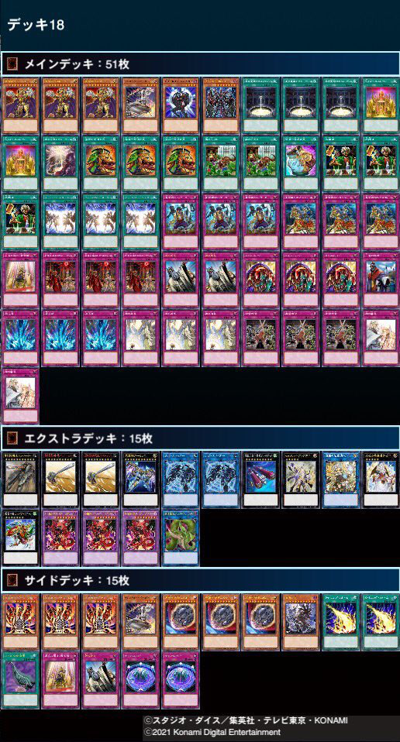

In [7]:
# Find deck path by deck_code
deck_code = '0007-001'
dir_deck = search_deck(deck_code)
#######################################################
image = Image.open(dir_deck)
o_size = image.size
f = 400
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

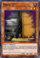

In [8]:
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
image=Image.open(dir_card)
o_size = image.size
f = 40
width, height = f, int(f*o_size[1]/o_size[0])
image = image.resize((width, height))
display(image)

# 2. Run with frequently used cards

In [24]:
# Parameters
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
print(f'Name of Card : {card_name}')
#######################################################
# Find deck path by deck_code
deck_code = '0007-001'
dir_deck = search_deck(deck_code)
print(f'Name of Deck : {deck_code}')
#######################################################
deck_width = 400
card_width = match_scale(dir_card, dir_deck, deck_width)
print(f'{deck_code} | Width of Deck         | {deck_width}')
print(f'{deck_code} | Width of Card         | {card_width}')
#######################################################
threshold = 0.75
dup_tol = math.ceil(card_width/1.95)
sort_round = math.ceil(card_width/1.95)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
# Sample To Test For
card_list = card_list_freq
digit_list = []
dir_card_list = []
for card in card_list:
    digit = search_card(card)
    digit_list.append(digit)
    dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
    dir_card_list.append(dir_card)
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')

Name of Card : 증식의 G
Name of Deck : 0007-001
0007-001 | Width of Deck         | 400
0007-001 | Width of Card         | 38
0007-001 | Matchng Threshold     | 0.75
0007-001 | Duplicate Tolearance  | 20
0007-001 | Sorting Round         | 20
0007-001 | Cards to match        | 28


In [25]:
# Plotter
args = [
    [dir_card, dir_deck, deck_width, card_width, threshold]
    for dir_card in dir_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
card_loc = [item[0][0] for item in result]
card_pos = [item[1][0] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)

print("Done Translation")
print(deck_list)

#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

Done Translation
['0007-001', '무덤의 지명자', '졸부와 겸허의 항아리', '무덤의 지명자', '무덤의 지명자', '신의 심판', '신의 심판', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '네가로기어 아제우스', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '원시생명체 니비루', '원시생명체 니비루', '원시생명체 니비루', '라이트닝 스톰', '라이트닝 스톰', '어리석은 매장', '신의 심판']


# 3. Run with Broader Card List

In [22]:
# Parameters
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
print(f'Name of Card : {card_name}')
#######################################################
# Find deck path by deck_code
deck_code = '0007-001'
dir_deck = search_deck(deck_code)
print(f'Name of Deck : {deck_code}')
#######################################################
deck_width = 400
threshold = 0.75
#######################################################
card_width_list = []
for dir_card in dir_card_list_freq:
    card_width = match_scale_mp(dir_card, dir_deck, deck_width, threshold)
    if card_width != None:
        card_width_list.append(card_width)
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
except ZeroDivisionError:
    card_width = round_near(deck_width/10.1)
    print("Zero Division Error")
print(f'{deck_code} | Width of Deck         | {deck_width}')
print(f'{deck_code} | Width of Card         | {card_width}')
print(f'-- {card_width_list} --' )
#######################################################
dup_tol = math.floor(card_width / 1.95)
sort_round = math.floor(card_width / 1.95)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
dir_card_db = f'{dir_main}/Data/used_db_abr.txt'
with open(dir_card_db) as file:
    digit_list = [ int(line.rstrip()) for line in file]
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')

Name of Card : 증식의 G
Name of Deck : 0007-001
0007-001 | Width of Deck         | 400
0007-001 | Width of Card         | 39
-- [38, 40, 39, 39, 40, 40, 40, 39] --
0007-001 | Matchng Threshold     | 0.75
0007-001 | Duplicate Tolearance  | 20
0007-001 | Sorting Round         | 20
0007-001 | Cards to match        | 7436


In [13]:
# Solver
args = [
    [dir_card, dir_deck, deck_width, card_width, threshold]
    for dir_card in dir_card_list
]
#####################################################################
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card, args)
pool.close()
#####################################################################
card_loc = [item[0][0] for item in result]
card_pos = [item[1][0] for item in result]
print("Done Solution")
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
print("Done Translation")
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
dir_write = f'{dir_main}/Output/single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

Done Solution
Done Translation


In [14]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = db_name_ko[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

# 5. Using Cache + Multi-processing

### 5-1 Parameters

In [26]:
# Parameters
card_name = "증식의 G"
digit = search_card(card_name)
dir_card = f'{dir_main}/YGO_DB/{digit}.jpg'
#######################################################
# Find deck path by deck_code
deck_code = '0007-001'
dir_deck = search_deck(deck_code)
#######################################################
deck_width = 400
print(f'{deck_code} | Width of Deck         | {deck_width}')
threshold = 0.7
card_width_list = []
for dir_card in dir_card_list_freq:
    card_width = match_scale_mp(dir_card, dir_deck, deck_width, threshold)
    if card_width != None:
        card_width_list.append(card_width)
#######################################################
try:
    card_width = round_near(sum(card_width_list) / len(card_width_list))
    print(f'{deck_code} | Width of Card         | {card_width}')
except ZeroDivisionError:
    card_width = round_near(deck_width/10.1)
    print(f"{deck_code} | Width of Card; Zero Div Error | {card_width}")
#######################################################
dup_tol = math.floor(card_width / 2)
sort_round = math.floor(card_width / 2)
print(f'{deck_code} | Matchng Threshold     | {threshold}')
print(f'{deck_code} | Duplicate Tolearance  | {dup_tol}')
print(f'{deck_code} | Sorting Round         | {sort_round}')
#######################################################
dir_card_db = f'{dir_main}/Data/used_db_abr.txt'
with open(dir_card_db) as file:
    digit_list = [ int(line.rstrip()) for line in file]
dir_card_list = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list]
print(f'{deck_code} | Cards to match        | {len(dir_card_list)}')
#######################################################
dir_deck_db = f'{dir_main}/Data/deck_db.txt'
with open(dir_deck_db) as file:
    deck_code_list = [line.rstrip() for line in file]
dir_deck_list = [
    f"{dir_main}/Deck/{deck_code}.jpg" for deck_code in deck_code_list
]
print(f'{deck_code} | Decks to match        | {len(dir_deck_list)}')

0007-001 | Width of Deck         | 400
0007-001 | Width of Card         | 39
0007-001 | Matchng Threshold     | 0.7
0007-001 | Duplicate Tolearance  | 19
0007-001 | Sorting Round         | 19
0007-001 | Cards to match        | 7436
0007-001 | Decks to match        | 470


### 5-2 Test Card Widths for list of decks

In [ ]:
average_list = []
for dir_deck in dir_deck_list:
    deck_code = os.path.splitext(os.path.basename(dir_deck))[0]
    card_width_list = []
    for dir_card in dir_card_list_freq:
        card_width = match_scale_mp(dir_card, dir_deck, deck_width, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    try:
        average = round_near(sum(card_width_list) / len(card_width_list))
        average_list.append(average)
        print(f'{deck_code} | average card width is : {average}')
    except ZeroDivisionError:
        pass
        print(f'{deck_code} | Zero Division Error')

list_average = round_near(sum(average_list) / len(average_list))
print(f'-- average card width for overall {list_average} --')

### 5-3 Single Instance

In [30]:
perf_round = 2

## Solution
#####################################################################
img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
#####################################################################
print(f'{deck_code} | Started Process                   | Run')
t1 = time.perf_counter()
#####################################################################
# Chcek Cache
cache_files = glob.glob(f'{dir_main}/Output/cache_*.npy')
cache_names = [os.path.splitext(os.path.basename(file))[0] for file in cache_files]
#####################################################################
if f'cache_{card_width:03d}' in cache_names:
    print(f'{deck_code} | -Found cache for {card_width:03d}              |')
else:
    print(f'{deck_code} | -No cache for {card_width:03d}                 |')
    # getting info
    dir_card_db_x = f'{dir_main}/Data/used_db_max.txt'
    with open(dir_card_db_x) as file:
        digit_list_x = [ int(line.rstrip()) for line in file]
    dir_card_list_x = [f"{dir_main}/YGO_DB/{digit}.jpg" for digit in digit_list_x]
    # resizing
    tcs = time.perf_counter()
    print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
    load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
    dict_card_list = dict(zip(digit_list_x , load_card_list))
    # saving cache
    dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    np.save(dir_cache_card_save, dict_card_list)
    print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
#####################################################################
# loading cache
tcl = time.perf_counter()
print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
#####################################################################
# Variables
tm = time.perf_counter()
args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
#####################################################################
# Solver
print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
with Pool(n_cpu-1) as pool:
    result = pool.starmap(match_card_v, args)
pool.close()
#####################################################################
print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
t2 = time.perf_counter()
#####################################################################
card_loc = [item[0][0] for item in result]
card_pos = [item[1][0] for item in result]
#####################################################################
# Translator
zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
dup_pt = trans_dup (zip_pt, dup_tol)
group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
sort_name = trans_name(sort_digit)
sort_type = trans_type(sort_digit)
deck_list = trans_paste(sort_name, sort_type, deck_code)
#####################################################################
master_db = ["\t".join(str(x) for x in deck_list)]
#####################################################################
print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
#####################################################################
dir_write = f'{dir_main}\Output\single_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

0007-001 | Started Process                   | Run
0007-001 | -Found cache for 039              |
0007-001 | -Loading cache for 039            |
0007-001 | -Loaded cache for 039             | 0.05
0007-001 | -Starting Templating Matching     | 0.01
0007-001 | -Finished Template Matching in    | 11.12
0007-001 | -Finished Translating in          | 4.44
0007-001 | Finished Process in               | = 15.62


In [ ]:
# Export Data
package = []
for i in range(len(digit_list)):
    digit = digit_list[i]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        pos = card_pos[i][j]
        ind = np.where(db_digit == int(digit))[0][0]
        name = db_name_ko[ind]
        package.append(f'{coX}, {coY}, {digit}, {pos}, {name}')
        # print(f'{coX}, {coY}, {digit}, {pos}, {name}')

dir_write = f'{dir_main}\Output\package.txt'
with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in package:
        fp.write("%s\n" % item)

### 5-4 Multiple Instance

In [ ]:
perf_round = 2
t0 = time.perf_counter()

it_a, it_b = 0, 100

master_db = []
for i in range(it_a,it_b):
    #####################################################################
    deck_code = deck_code_list[i]
    dir_deck = dir_deck_list[i]
    #####################################################################
    print('======================================================')
    print(f'{deck_code} | Started Process                   | Run {i}/({it_b}-{it_a})')
    t1 = time.perf_counter()
    #####################################################################
    img_deck = cv2.cvtColor(imutils.resize(cv2.imread(dir_deck), width=deck_width), cv2.COLOR_BGR2GRAY)
    card_width_list = []
    for dir_card in dir_card_list_freq:
        card_width = match_scale_mp(dir_card, dir_deck, deck_width, threshold)
        if card_width != None:
            card_width_list.append(card_width)
    #######################################################
    print(f'{deck_code} | -Width of Deck                    | {deck_width}')
    try:
        card_width = round_near(sum(card_width_list) / len(card_width_list))
        print(f'{deck_code} | -Width of Card                    | {card_width}')
    except ZeroDivisionError:
        card_width = round_near(deck_width/10.1)
        print(f"{deck_code} | -Width of Card; Zero Div Error    | {card_width}")
    #######################################################
    dup_tol = math.floor(card_width / 2)
    sort_round = math.floor(card_width / 2)
    #######################################################
    # Check Cache
    cache_files = glob.glob(f'{dir_main}/Output/cache_*.npy')
    cache_names = [os.path.splitext(os.path.basename(file))[0] for file in cache_files]
    if f'cache_{card_width:03d}' in cache_names:
        print(f'{deck_code} | -Found cache for {card_width:03d}              |')
    else:
        print(f'{deck_code} | -No cache for {card_width:03d}                 |')
        # getting info
        dir_card_img = f'{dir_main}/YGO_DB/'
        dir_card_db_x = f'{dir_main}/Data/used_db_max.txt'
        with open(dir_card_db_x) as file:
            digit_list_x = [ int(line.rstrip()) for line in file]
        dir_card_list_x = [f"{dir_card_img}{digit}.jpg" for digit in digit_list_x]
        #####################################################################
        tcs = time.perf_counter()
        print(f'{deck_code} | -Saving cache for {card_width:03d}             |')
        #####################################################################
        # resizing
        load_card_list = [imutils.resize(cv2.imread(dir_card, 0), width=card_width) for dir_card in dir_card_list_x]
        dict_card_list = dict(zip(digit_list_x , load_card_list))
        # saving cache
        dir_cache_card_save = f'{dir_main}/Output/cache_{card_width:03d}.npy'
        np.save(dir_cache_card_save, dict_card_list)
        print(f'{deck_code} | -Saved cache for {card_width:03d}              | { round(time.perf_counter() - tcs , perf_round)}')
    #####################################################################
    # loading cache
    tcl = time.perf_counter()
    print(f'{deck_code} | -Loading cache for {card_width:03d}            |')
    dir_cache_card_open = f'{dir_main}/Output/cache_{card_width:03d}.npy'
    cache_card_list = np.load(dir_cache_card_open, allow_pickle=True)
    filter_card_list = [ cache_card_list.item()[digit] for digit in digit_list ]
    print(f'{deck_code} | -Loaded cache for {card_width:03d}             | { round(time.perf_counter() - tcl , perf_round)}')
    #####################################################################
    # Variables
    tm = time.perf_counter()
    args = [[img_card, img_deck, threshold] for img_card in filter_card_list]
    #####################################################################
    # Solver
    print(f'{deck_code} | -Starting Templating Matching     | { round(time.perf_counter() - tm , perf_round)}')
    with Pool(10) as pool:
        result = pool.starmap(match_card_v, args)
    pool.close()
    #####################################################################
    print(f"{deck_code} | -Finished Template Matching in    | { round(time.perf_counter() - tm , perf_round)}")
    t2 = time.perf_counter()
    #####################################################################
    card_loc = [item[0][0] for item in result]
    card_pos = [item[1][0] for item in result]
    #####################################################################
    # Translator
    zip_digit, zip_pt, zip_pos = trans_raw ( card_loc, card_pos , digit_list)
    dup_pt = trans_dup (zip_pt, dup_tol)
    group_pt, group_pos, group_digit = trans_group (dup_pt, zip_pt, zip_pos, zip_digit, dup_tol)
    sort_digit = trans_sort (group_pos, group_digit , group_pt , sort_round)
    sort_name = trans_name(sort_digit)
    sort_type = trans_type(sort_digit)
    deck_list = trans_paste(sort_name, sort_type, deck_code)
    #####################################################################
    master_db.append("\t".join(str(x) for x in deck_list))
    #####################################################################
    print(f"{deck_code} | -Finished Translating in          | { round(time.perf_counter() - t2 , perf_round)}")
    print(f"{deck_code} | Finished Process in               | = { round(time.perf_counter() - t1 , perf_round)}")
    #####################################################################
dir_write = f'{dir_main}\Output\mp_stack.txt'
open(dir_write, 'w').close()
with open(dir_write , 'w', encoding="utf-8") as fp:
    for item in master_db:
        fp.write("%s\n" % item)
os.startfile(dir_write)

print(f'________ | Gross Computation                 | { round(time.perf_counter() - t0 , perf_round)}')

## 0. Test Worker

In [ ]:
import time
for i in range(6,cpu_count-1):
    t = time.time()
    # Variable
    args = []
    for img_card in load_card_list:
        args.append([img_card, img_deck, threshold])
    # Solver
    with Pool(i) as pool:
        result = pool.starmap(match_card_v, args)
        pool.close()
    print( f'{i} worker : { (time.time() - t) }')